# Comparison between empirical and predicted pipeline similarities

In [1]:
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

#wd = "D:/Meteor/Projects/RLproject/Guardian/Scripts/"
wd = "/mnt/hpc_work/"
#wd = "/gss/work/zead9360/"

file_paths = [f"{wd}/GCN-pipelines/multiverse/multiverse_pipelines/results/universe_{i}.pkl" for i in range(1, 15)] 
gcn_data = f"{wd}/GCN-pipelines/Data/graph_and_embeddings.pkl" 
pipeline_path = f"{wd}/GCN-pipelines/Data/pipelinesMultiverse.xlsx"

The empirical similarity is estimated for 14 different pipelines as defined in the multiverse analysis in `mverse.py`:

In [2]:
universes_data = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        universe = pickle.load(file)
        universes_data.append(list(universe.values()))

empirical_similarity = np.corrcoef(np.array(universes_data))

Data from the trained GCN network is loaded:

In [3]:
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]

# Load pipelines and trained embeddings
pipeline_df = pd.read_excel(pipeline_path, index_col=0)
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}

2024-11-26 16:31:17.047650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 16:31:17.052383: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:31:17.090544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:31:17.091690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 16:31:17.888837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Predicted pipeline dissimilarity:

In [4]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)  # Use mean sequence as reference
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# GCN-DTW
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embeddings_dict[node] for node in pipeline if node in embeddings_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw)

dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Comparing the predicted similarities with the empirical results from the multiverse analysis:

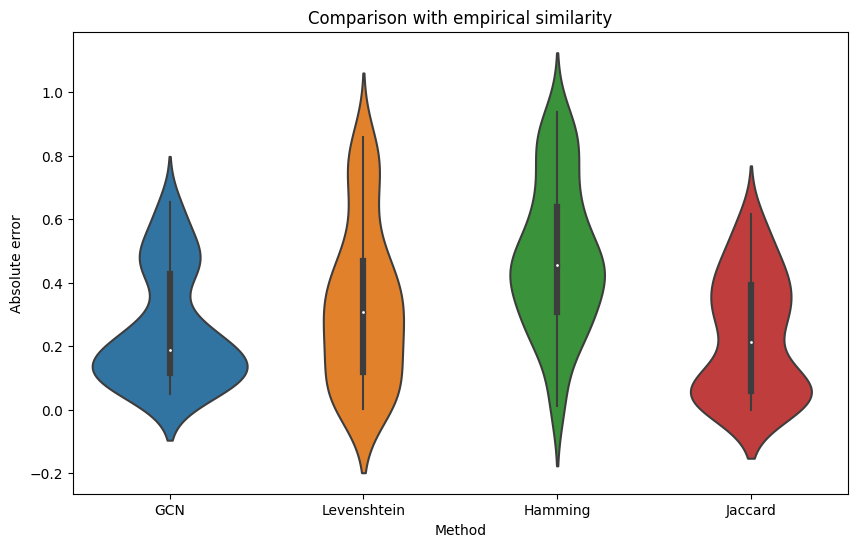

Mean Squared Errors:
 GCN            0.251097
Levenshtein    0.329372
Hamming        0.479787
Jaccard        0.227614
dtype: float64

Median Squared Errors:
 GCN            0.186975
Levenshtein    0.307780
Hamming        0.454204
Jaccard        0.213066
dtype: float64


In [5]:
empirical_upper = empirical_similarity[np.triu_indices_from(empirical_similarity, k=1)]
gcn_upper = embedding_similarity_dtw[np.triu_indices_from(embedding_similarity_dtw, k=1)]
levenshtein_upper = levenshtein_similarity[np.triu_indices_from(levenshtein_similarity, k=1)]
hamming_upper = hamming_similarity[np.triu_indices_from(hamming_similarity, k=1)]
jaccard_upper = jaccard_similarity[np.triu_indices_from(jaccard_similarity, k=1)]

similarity_data = pd.DataFrame({
    'Empirical': empirical_upper,
    'GCN': gcn_upper,
    'Levenshtein': levenshtein_upper,
    'Hamming': hamming_upper,
    'Jaccard': jaccard_upper
})

# Calculate absolute errors
absolute_errors = {
    'GCN': np.abs(similarity_data['Empirical'] - similarity_data['GCN']),
    'Levenshtein': np.abs(similarity_data['Empirical'] - similarity_data['Levenshtein']),
    'Hamming': np.abs(similarity_data['Empirical'] - similarity_data['Hamming']),
    'Jaccard': np.abs(similarity_data['Empirical'] - similarity_data['Jaccard']),
}

squared_error_data = pd.DataFrame(absolute_errors)
melted_squared_error_data = squared_error_data.melt(var_name='Method', value_name='Absolute Error') # melt the DataFrame for visualization

# Plot violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x='Method', y='Absolute Error', data=melted_squared_error_data)
plt.title('Comparison with empirical similarity')
plt.ylabel('Absolute error')
plt.xlabel('Method')
plt.show()

mean_squared_errors = squared_error_data.mean()
median_squared_errors = squared_error_data.median()

print("Mean Squared Errors:\n", mean_squared_errors)
print("\nMedian Squared Errors:\n", median_squared_errors)


In [6]:
import palmerpenguins
import ptitprince as pt

penguins = palmerpenguins.load_penguins().dropna()

print(penguins.head())
print(melted_squared_error_data)



  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007  
      Method  Absolute Error
0        GCN        0.271297
1        GCN        0.218907
2        GCN        0.503240
3        GCN        0.437534
4        GCN        0.165078
..       ...             ...
359  Jaccard        0.475456
360  Jaccard        0.585619
361  Jaccard        0.348474
362  Jaccard        0.392250
363  Jaccard        0.098045

[364 rows x 2 column

Try raincloud plots:

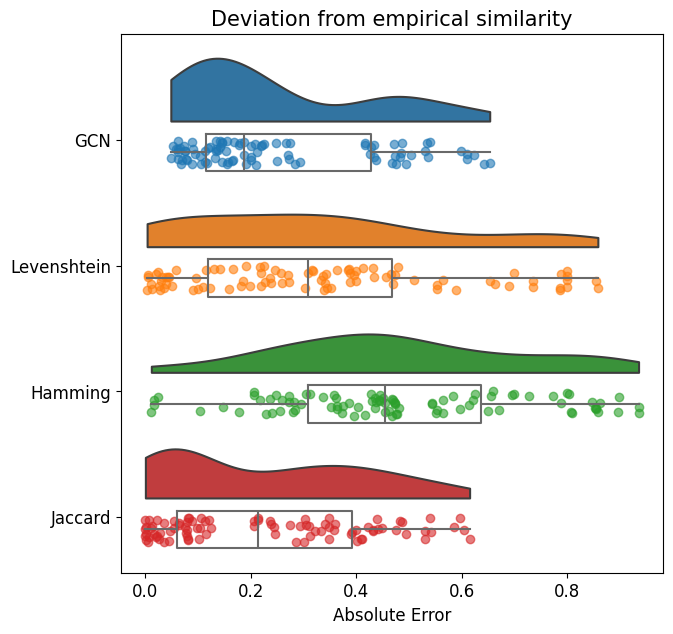

In [24]:
data = melted_squared_error_data.copy()

METHOD = ["GCN", "Levenshtein", "Hamming", "Jaccard"]
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT, 3 + SHIFT]

boxplot_data = [data[data["Method"] == method]["Absolute Error"].values for method in METHOD]

medianprops = {"linewidth": 1.5, "color": "#696969", "solid_capstyle": "butt"}
boxprops = {"linewidth": 1.5, "color": "#696969"}

fig, ax = plt.subplots(figsize=(7, 7))

# Plot the half-violin plots
pt.half_violinplot(
    x="Absolute Error", y="Method",
    inner=None, data=data, width=1, ax=ax, cut=0
)

# Scatter points
for i, method in enumerate(METHOD):
    method_data = data[data["Method"] == method]
    y = i + np.random.uniform(high=0.2, size=len(method_data))  # Add jitter
    x = method_data["Absolute Error"]
    ax.scatter(x, y, alpha=0.6)

# Boxplots
ax.boxplot(
    boxplot_data,
    vert=False,
    positions=POSITIONS,
    widths=0.3, 
    manage_ticks=False,
    showfliers=False,
    showcaps=False,
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Axes and labels
ax.set_xlabel("Absolute Error", fontsize=12)
ax.set_ylabel("")
ax.set_title("Deviation from empirical similarity", fontsize=15)
ax.tick_params(labelsize=12)
plt.show()
